<a href="https://colab.research.google.com/github/Patrick5455/Customer-Churn-Prediction/blob/master/modelling/customer_churn_modelling_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  
drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import some libraries
import pandas as pd
from pandas.api.types import is_string_dtype 
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt 
from pylab import rcParams  
import seaborn as sns 
import os 
sns.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


> Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import IsolationForest 
from imblearn.over_sampling import SMOTE

Modelling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import  Pipeline as ImbPipe
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import scorer, log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, plot_roc_curve, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import RFECV
# from sklearn.feature_extraction import 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2, SelectPercentile

from sklearn.compose import make_column_selector as selector

from sklearn.svm import SVC

In [ ]:
# sklearn.feature_extraction.

> > Project packages

In [ ]:
# from project_package.data_package import data
# from project_package.model_package import model, model_metrics
# from project_package.plot_package import bi_plot, uni_plot
# 

In [ ]:
# ?KNNImputer

> Load Datasets

In [ ]:
#g-drive paths
train = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/AIMS_Train.csv'
test = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/AIMS_Test.csv'
variables = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/VariableDefinitions.csv'
submissions = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/AIMS_SampleSubmission.csv' 

In [ ]:
models_path = '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/saved_models/'
predictions_path =  '/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/predictions/' 

In [ ]:
#colab
train = pd.read_csv(train)
test=  pd.read_csv(test)
submission = pd.read_csv(submissions)
variables = pd.read_csv(variables, header=2)

In [ ]:
print(train.shape)
print(test.shape)

(646214, 19)
(114038, 18)


In [ ]:
#import data - jupyter localhost

# train = pd.read_csv('../datasets/AIMS_Train.csv')
# test=  pd.read_csv('../datasets/AIMS_Test.csv')
# submission = pd.read_csv('../datasets/AIMS_SampleSubmission.csv')
# variables = pd.read_csv('../datasets/VariableDefinitions.csv')

#### Define Utility Functions

> Calculate number of levels in categorical variables

In [ ]:
def check_levels(data, exclude_cols=[]):
    cat_cols = data.select_dtypes(include='object').columns.tolist()
    
    for col in cat_cols:
        if col not in exclude_cols:
            print('*-*'*10,'\n')
            print(data[col].value_counts())
            plt.figure(figsize=(10,5)) 
            plt.title(f"Value Counts of {col}", fontsize=15)
            data[col].value_counts(normalize=True).plot(kind='bar')
            print('*-*'*10,'\n')
            plt.ylabel('counts')
            plt.xlabel(col)

> check for null values

In [ ]:
def check_null(data, plot=True):
    print(data.isnull().sum()) 
    if plot:
        plt.figure(figsize=(10,5))
        plt.title(f"Null Values Count", fontsize=15)
        data.isnull().sum().plot.bar()

> check for outliers

In [ ]:
def check_outliers(data, show_plot=False, save_img=os.getcwd()+'/outliers.png'):
 
        """
        This functions checks for columns with outlers using the IQR method

        It accespts as argmuent a dataset. 
        show_plot can be set to True to output pairplots of outlier columns    
        """

        outliers = [] 
        Q1 = data.quantile(0.25)  
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1 
        num_data = data.select_dtypes(include=['float64', 'int64'])
        result = dict (((num_data < (Q1 - 1.5 * IQR)) | (num_data > (Q3 + 1.5 * IQR))).any())
        print(result)  
        index = data[(num_data < Q1 - 1.5 * IQR) | (num_data > Q3 + 1.5 * IQR)].index
        for k,v in result.items(): 
            if v == True:  
                outliers.append(k) 
        if show_plot:
            outlier_pair_plot = sns.pairplot(data[outliers]); 
            print(f'{result},\n\n Visualization of outlier columns')
            plt.savefig(fname=save_img, format='png')
            return  outlier_pair_plot
        else:
            print(data.shape)
            return data.loc[index, outliers] 

> Define functions to mesaure predictions performance


In [ ]:
class PredMetrics():

  def __init__(self, X, y, y_pred, y_true, model, scorer:make_scorer,
                 verbose=False, cv=StratifiedKFold(random_state=123)):
    
    self.X = X 
    self.y = y
    self.y_pred = y_pred
    self.y_true = y_true
    self.model = model
    self.scorer = scorer
    self.cv = cv 

  def __repr__(self):
    return "Prediction Metrics"

  
  def cv_score(self):

     self.cv_score_metric = cross_val_score(model = self.model, X=self.X, y=self.y, scoring = self.scorer, verbose=verbose, cv=self.cv)

     return self.cv_score_metric

  def conf_matrix(self):

    self.conf_matrix_metric = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)

    return self.conf_matrix_metric

  def log_loss_score(self):

    self.log_loss_metric = log_loss(y_true = self.y_true, y_pred = self.y_pred)

    return self.log_loss_metric

  def roc_curve(self):

    self.plot_roc_metric = plot_roc_curve(self.model, X=self.X, y = self.y)
      
    return self.plot_roc_metric
  
  def class_report(self):

    self.class_report_metric = classification_report_imbalanced(y_true = self.y_true, y_pred = self.y_pred)

    return self.class_report_metric

> Define functions to save satisifed predictions

In [ ]:
def save_pred(y_hat, test_set, file_name ="new_submission"):
  prediction_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/submissions/'
  from datetime import datetime
  file_name=file_name+datetime.now().strftime('%Y-%m-%d')
  submissions = pd.DataFrame({'ID X PCODE':test_set['ID X PCODE'],'Label':y_hat})
  submissions.to_csv(prediction_path+file_name, index=False)
  return submissons 

#### Define Custom Estimators

In [ ]:
variables

,Unnamed: 0,Le dataset churn comprend 19 variables dont 15 variables numeriques et 04 variables categoriques.,The churn dataset includes 19 variables including 15 numeric variables and 04 categorical variables.
0,user_id,NaN,NaN
1,REGION,la localité de chaque client,the location of each client
2,TENURE,la durée dans le reseau,duration in the network
3,MONTANT,montant de recharge,top-up amount
4,FREQUENCE_RECH,nombre de fois que le client a fait une recharge,number of times the customer refilled
5,REVENUE,revenu mensuel de chaque client,monthly income of each client
6,ARPU_SEGMENT,revenu sur 90 jours/3,income over 90 days / 3
7,FREQUENCE,nombre de fois que client à fait un revenu,number of times the client has made an income
8,DATA_VOLUME,nombre de connexions,number of connections
9,ON_NET,appel inter expresso,inter expresso call


In [ ]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646214 entries, 0 to 646213
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         646214 non-null  object 
 1   REGION          391246 non-null  object 
 2   TENURE          646214 non-null  object 
 3   MONTANT         419154 non-null  float64
 4   FREQUENCE_RECH  419154 non-null  float64
 5   REVENUE         428459 non-null  float64
 6   ARPU_SEGMENT    428459 non-null  float64
 7   FREQUENCE       428459 non-null  float64
 8   DATA_VOLUME     327544 non-null  float64
 9   ON_NET          409962 non-null  float64
 10  ORANGE          377516 non-null  float64
 11  TIGO            259060 non-null  float64
 12  ZONE1           50406 non-null   float64
 13  ZONE2           41072 non-null   float64
 14  MRG             646214 non-null  object 
 15  REGULARITY      646214 non-null  int64  
 16  TOP_PACK        375331 non-null  object 
 17  FREQ_TOP_P

In [ ]:
# train.drop(columns=['REGION', 'TOP_PACK', 'MRG'], inplace=True) 
train #s= train.sample(frac=.3, random_state=123) 
train.head() 

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,NO,22,"Data:1000F=2GB,30d",1.0,0
1,3322a4900689f7f3cb14b8f9ea00778853f02d75,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,0
2,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,NO,8,"Data: 100 F=40MB,24H",3.0,0
3,98c44b62c33c6a1d9dbcf5e918868419f249c4a8,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
4,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,NO,9,NaN,NaN,0


In [ ]:
train.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
646209,1c778c81cdcc43cb410db142935d1483367c24aa,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
646210,e13ff861de0ffd7a51084963634ccd027597511c,SAINT-LOUIS,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,28.0,53.0,NaN,NaN,NaN,NO,32,MIXT:500F= 2500F on net _2500F off net;2d,2.0,0
646211,03ec81dadb13af0876d579a24a033ab27e7e2913,THIES,K > 24 month,13000.0,26.0,14000.0,4667.0,26.0,NaN,2973.0,183.0,50.0,NaN,NaN,NO,58,On-net 500F_FNF;3d,15.0,0
646212,c265e207e32f0573881ddcfa312022ee33372d4b,NaN,K > 24 month,3100.0,4.0,3033.0,1011.0,4.0,12905.0,NaN,0.0,NaN,NaN,NaN,NO,24,"Data:1000F=5GB,7d",3.0,0
646213,3fab267c587943cd2afedf8066b6a4b698220421,KOLDA,K > 24 month,6500.0,12.0,6500.0,2167.0,11.0,NaN,49.0,220.0,NaN,NaN,NaN,NO,57,All-net 500F =2000F_AllNet_Unlimited,13.0,0


In [ ]:
train.shape

(646214, 19)

In [ ]:
#view the data types in the train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646214 entries, 0 to 646213
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         646214 non-null  object 
 1   REGION          391246 non-null  object 
 2   TENURE          646214 non-null  object 
 3   MONTANT         419154 non-null  float64
 4   FREQUENCE_RECH  419154 non-null  float64
 5   REVENUE         428459 non-null  float64
 6   ARPU_SEGMENT    428459 non-null  float64
 7   FREQUENCE       428459 non-null  float64
 8   DATA_VOLUME     327544 non-null  float64
 9   ON_NET          409962 non-null  float64
 10  ORANGE          377516 non-null  float64
 11  TIGO            259060 non-null  float64
 12  ZONE1           50406 non-null   float64
 13  ZONE2           41072 non-null   float64
 14  MRG             646214 non-null  object 
 15  REGULARITY      646214 non-null  int64  
 16  TOP_PACK        375331 non-null  object 
 17  FREQ_TOP_P

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114038 entries, 0 to 114037
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         114038 non-null  object 
 1   REGION          69081 non-null   object 
 2   TENURE          114038 non-null  object 
 3   MONTANT         74135 non-null   float64
 4   FREQUENCE_RECH  74135 non-null   float64
 5   REVENUE         75854 non-null   float64
 6   ARPU_SEGMENT    75854 non-null   float64
 7   FREQUENCE       75854 non-null   float64
 8   DATA_VOLUME     58049 non-null   float64
 9   ON_NET          72436 non-null   float64
 10  ORANGE          66823 non-null   float64
 11  TIGO            45908 non-null   float64
 12  ZONE1           9011 non-null    float64
 13  ZONE2           7217 non-null    float64
 14  MRG             114038 non-null  object 
 15  REGULARITY      114038 non-null  int64  
 16  TOP_PACK        66425 non-null   object 
 17  FREQ_TOP_P

In [ ]:
# test.drop(columns=['REGION', 'TOP_PACK', 'MRG'], inplace=True) 
test #= test.sample(frac=.3, random_state=123)
test.head()  

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,c1b31e7cef249f2b777d934886b787a433029263,DAKAR,K > 24 month,10600.0,18.0,11099.0,3700.0,22.0,4004.0,60.0,123.0,19.0,NaN,NaN,NO,61,All-net 500F=2000F;5d,9.0
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,7.0,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,THIES,K > 24 month,17900.0,36.0,18405.0,6135.0,44.0,0.0,446.0,50.0,28.0,2.0,NaN,NO,62,On-net 1000F=10MilF;10d,9.0
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,DAKAR,K > 24 month,10000.0,10.0,10001.0,3334.0,27.0,NaN,0.0,93.0,8.0,NaN,NaN,NO,45,All-net 500F=2000F;5d,12.0
4,96c6a822243654ae1fe5f5f887089681f806cb46,THIES,K > 24 month,500.0,1.0,500.0,167.0,1.0,NaN,8.0,14.0,NaN,NaN,NaN,NO,8,All-net 500F=2000F;5d,1.0


In [ ]:
test.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
114033,5716c645907ed2fc642414ce4072eddf284ede08,NaN,K > 24 month,200.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,5,NaN,NaN
114034,473fd291ae14644a757f86a76838820c1ddf7859,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
114035,e0457edfc3a4feafabe4108d89187390e85c64a9,DIOURBEL,K > 24 month,2200.0,2.0,3501.0,1167.0,4.0,7110.0,1.0,NaN,16.0,NaN,NaN,NO,59,"Data:1500F=SPPackage1,30d",2.0
114036,75f9e5ce36caef56d7c253e1cf92af68c1ece956,KAOLACK,K > 24 month,9800.0,21.0,9879.0,3293.0,21.0,18651.0,37.0,0.0,NaN,NaN,NaN,NO,61,"Data:490F=1GB,7d",15.0
114037,42e019de7bc1ae30bc617df9e2c1b8869c2420e6,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN


In [ ]:
test.shape 

(114038, 18)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114038 entries, 0 to 114037
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         114038 non-null  object 
 1   REGION          69081 non-null   object 
 2   TENURE          114038 non-null  object 
 3   MONTANT         74135 non-null   float64
 4   FREQUENCE_RECH  74135 non-null   float64
 5   REVENUE         75854 non-null   float64
 6   ARPU_SEGMENT    75854 non-null   float64
 7   FREQUENCE       75854 non-null   float64
 8   DATA_VOLUME     58049 non-null   float64
 9   ON_NET          72436 non-null   float64
 10  ORANGE          66823 non-null   float64
 11  TIGO            45908 non-null   float64
 12  ZONE1           9011 non-null    float64
 13  ZONE2           7217 non-null    float64
 14  MRG             114038 non-null  object 
 15  REGULARITY      114038 non-null  int64  
 16  TOP_PACK        66425 non-null   object 
 17  FREQ_TOP_P

In [ ]:
submission.head()

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0
4,96c6a822243654ae1fe5f5f887089681f806cb46,0


In [ ]:
submission.shape

(114038, 2)

In [ ]:
submission.CHURN.value_counts()

0    114038
Name: CHURN, dtype: int64

#### Data Wrangling

> calculate number of levels in columns

*-**-**-**-**-**-**-**-**-**-* 

DAKAR          154267
THIES           53902
SAINT-LOUIS     35882
LOUGA           29629
KAOLACK         29057
DIOURBEL        20083
TAMBACOUNDA     16449
KAFFRINE        13113
KOLDA           11511
FATICK          10676
MATAM            8755
ZIGUINCHOR       6664
SEDHIOU           972
KEDOUGOU          286
Name: REGION, dtype: int64
*-**-**-**-**-**-**-**-**-**-* 

*-**-**-**-**-**-**-**-**-**-* 

K > 24 month     613231
I 18-21 month     13412
H 15-18 month      7753
G 12-15 month      4372
J 21-24 month      3875
F 9-12 month       2805
E 6-9 month         557
D 3-6 month         209
Name: TENURE, dtype: int64
*-**-**-**-**-**-**-**-**-**-* 

*-**-**-**-**-**-**-**-**-**-* 

NO    646214
Name: MRG, dtype: int64
*-**-**-**-**-**-**-**-**-**-* 

*-**-**-**-**-**-**-**-**-**-* 

All-net 500F=2000F;5d             95425
On net 200F=Unlimited _call24H    45713
Data:490F=1GB,7d                  34513
Data: 100 F=40MB,24H              25538
Mixt 250F=Unlimite

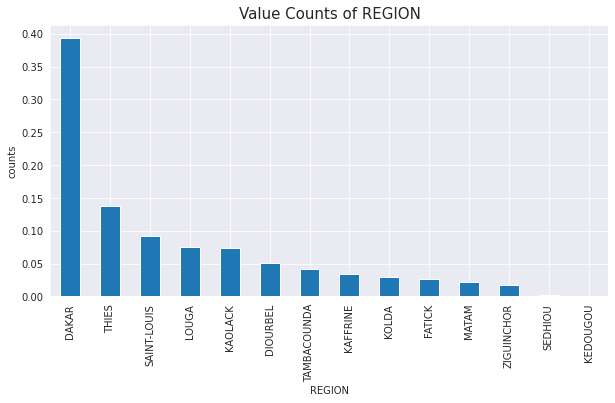

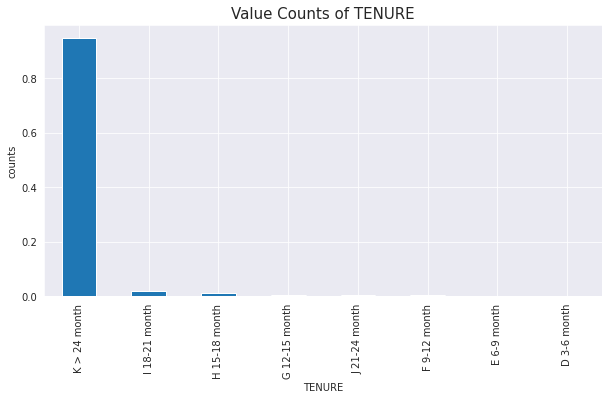

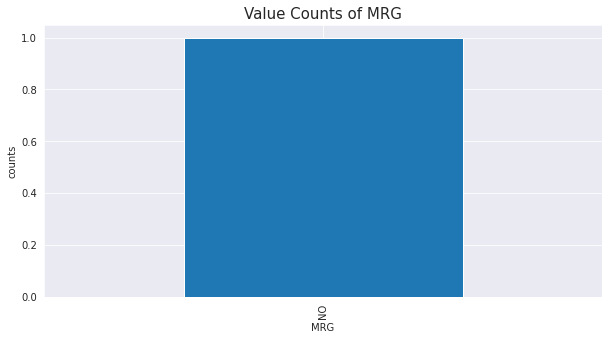

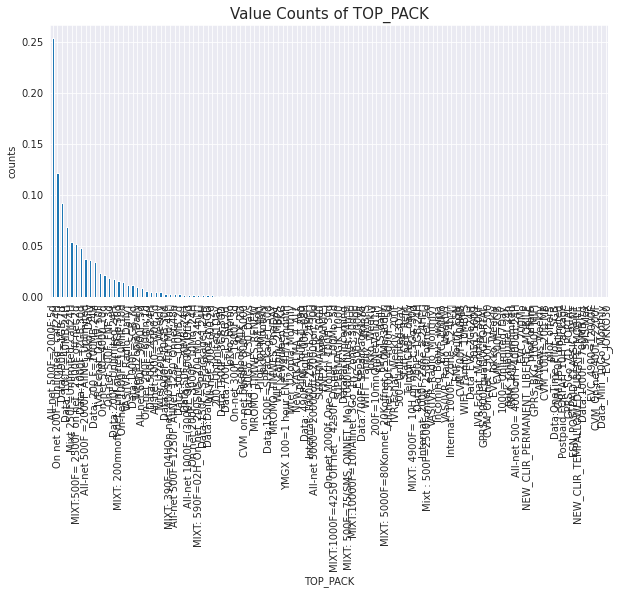

In [ ]:
check_levels(train, exclude_cols=['user_id']) 

Compute statistics for numerical variables

In [ ]:
train.describe()  

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
count,419154.000000,419154.000000,428459.000000,428459.000000,428459.000000,3.275440e+05,409962.000000,377516.000000,259060.000000,50406.000000,41072.000000,646214.000000,375331.000000,646214.000000
mean,5535.843227,11.529891,5509.610712,1836.543270,13.975855,3.372705e+03,277.649655,95.274982,23.070601,7.987779,7.547478,28.038812,9.284301,0.187712
std,7161.605662,13.270572,7209.607287,2403.197321,14.689824,1.341078e+04,868.891990,202.764409,63.219602,39.546312,33.370589,22.282758,12.350381,0.390482
min,10.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000e+00,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000,2.000000,0.000000
50%,3000.000000,7.000000,3000.000000,1000.000000,9.000000,2.600000e+02,27.000000,29.000000,6.000000,1.000000,2.000000,24.000000,5.000000,0.000000
75%,7400.000000,16.000000,7382.000000,2461.000000,20.000000,2.875000e+03,157.000000,99.000000,20.000000,4.000000,5.000000,51.000000,12.000000,0.000000
max,290500.000000,132.000000,397968.000000,132656.000000,91.000000,1.823866e+06,36687.000000,6721.000000,4174.000000,1867.000000,1796.000000,62.000000,629.000000,1.000000


> Check for null values

user_id                0
REGION            254968
TENURE                 0
MONTANT           227060
FREQUENCE_RECH    227060
REVENUE           217755
ARPU_SEGMENT      217755
FREQUENCE         217755
DATA_VOLUME       318670
ON_NET            236252
ORANGE            268698
TIGO              387154
ZONE1             595808
ZONE2             605142
MRG                    0
REGULARITY             0
TOP_PACK          270883
FREQ_TOP_PACK     270883
CHURN                  0
dtype: int64


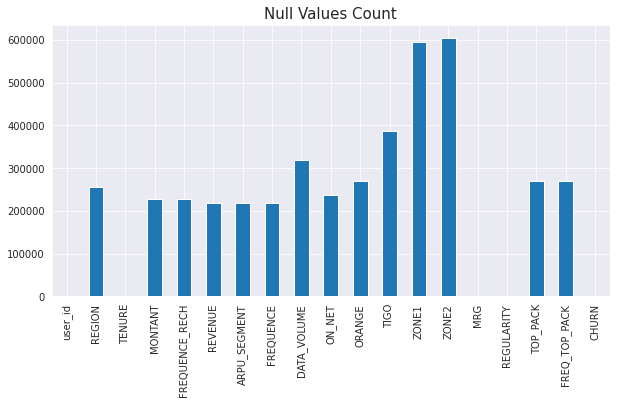

In [ ]:
check_null(train)

user_id                0
REGION             44957
TENURE                 0
MONTANT            39903
FREQUENCE_RECH     39903
REVENUE            38184
ARPU_SEGMENT       38184
FREQUENCE          38184
DATA_VOLUME        55989
ON_NET             41602
ORANGE             47215
TIGO               68130
ZONE1             105027
ZONE2             106821
MRG                    0
REGULARITY             0
TOP_PACK           47613
FREQ_TOP_PACK      47613
dtype: int64


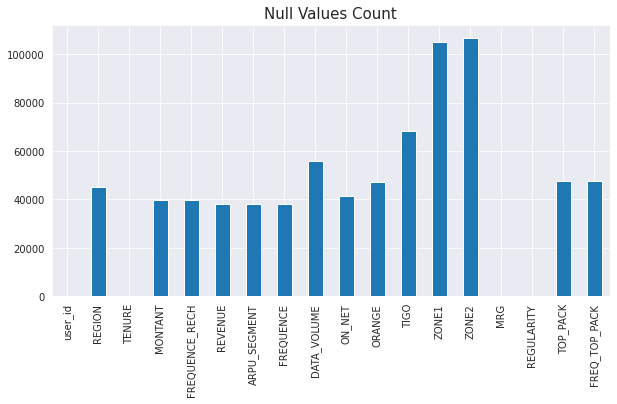

In [ ]:
check_null(test)

> There are a lot of null values in the dataset

outliers in train set

In [ ]:
check_outliers(train, show_plot=False)  

{'MONTANT': True, 'FREQUENCE_RECH': True, 'REVENUE': True, 'ARPU_SEGMENT': True, 'FREQUENCE': True, 'DATA_VOLUME': True, 'ON_NET': True, 'ORANGE': True, 'TIGO': True, 'ZONE1': True, 'ZONE2': True, 'REGULARITY': False, 'FREQ_TOP_PACK': True, 'CHURN': True}
(646214, 19)


,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK,CHURN
0,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,1.0,0
1,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,3.0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
646209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
646210,1500.0,3.0,1500.0,500.0,3.0,NaN,28.0,53.0,NaN,NaN,NaN,2.0,0
646211,13000.0,26.0,14000.0,4667.0,26.0,NaN,2973.0,183.0,50.0,NaN,NaN,15.0,0
646212,3100.0,4.0,3033.0,1011.0,4.0,12905.0,NaN,0.0,NaN,NaN,NaN,3.0,0


> most columns in the train set contain outlier values

outliers in test set

In [ ]:
check_outliers(test, show_plot=False)   

{'MONTANT': True, 'FREQUENCE_RECH': True, 'REVENUE': True, 'ARPU_SEGMENT': True, 'FREQUENCE': True, 'DATA_VOLUME': True, 'ON_NET': True, 'ORANGE': True, 'TIGO': True, 'ZONE1': True, 'ZONE2': True, 'REGULARITY': False, 'FREQ_TOP_PACK': True}
(114038, 18)


,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK
0,10600.0,18.0,11099.0,3700.0,22.0,4004.0,60.0,123.0,19.0,NaN,NaN,9.0
1,NaN,NaN,NaN,NaN,NaN,0.0,7.0,NaN,NaN,NaN,NaN,NaN
2,17900.0,36.0,18405.0,6135.0,44.0,0.0,446.0,50.0,28.0,2.0,NaN,9.0
3,10000.0,10.0,10001.0,3334.0,27.0,NaN,0.0,93.0,8.0,NaN,NaN,12.0
4,500.0,1.0,500.0,167.0,1.0,NaN,8.0,14.0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
114033,200.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114035,2200.0,2.0,3501.0,1167.0,4.0,7110.0,1.0,NaN,16.0,NaN,NaN,2.0
114036,9800.0,21.0,9879.0,3293.0,21.0,18651.0,37.0,0.0,NaN,NaN,NaN,15.0


> check for duplicate values

In [ ]:
train.duplicated().any()

False

In [ ]:
test.duplicated().any()

False

> check for class imbalance

Class Imbalance

0    524912
1    121302
Name: CHURN, dtype: int64 



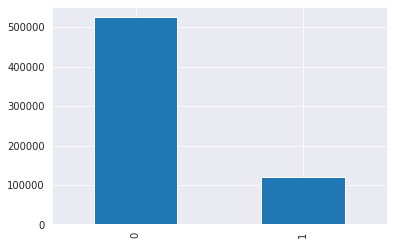

In [ ]:
print("Class Imbalance\n")
print(train.CHURN.value_counts(), "\n") 
train.CHURN.value_counts().plot.bar(); 

### Preprocess Data for Modelling
 > Cleaning
  - Drop MRG column
  - Remove outliers
  - Impute NaN by KNNImputer/SimpleImputer(mean/median for numerical and most frequent for categorical)

> Feature Engineering
 - Extract feature of users' rank by (Group of Region by Tenure) 
 - Extract feature users' rank  by TOPPACK
 - Balance Class Imbalance
 - Feature Union (K-best Selector and PCA components)

> Put all processes in Sklearn Pipeline



> Separate Y Labels from train set

In [ ]:
train, train_label = train.drop('CHURN', axis=1), train.CHURN 

In [ ]:
train_label.value_counts() 

0    524912
1    121302
Name: CHURN, dtype: int64

In [ ]:
train.shape

(646214, 18)

In [ ]:
test.shape

(114038, 18)

#### Define Custom Estimators and Functions for each Preprocessing steps


> Drop Columns

In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):

  """
  Drop Columns not needed 
  """

  def __init__(self, cols_to_drop:list):
    self.cols_to_drop = cols_to_drop

  def fit(self, X:pd.DataFrame, y=None):
    self.X_copy_ = X.copy()

    return self

  def transform(self, X, y=None):
    self.X_copy_ = X.copy()
    self.X_copy_ = self.X_copy_.drop(self.cols_to_drop, axis=1)

    return self.X_copy_   


  def fit_transform(self, X:pd.DataFrame, y=None):
    self = self.fit(X)

    self.X_copy_ = self.transform(X)

    return self.X_copy_

In [ ]:
drop_col = DropColumns(cols_to_drop=['MRG', 'user_id'])   
train_process = drop_col.fit_transform(train)  
train_process    

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,22,"Data:1000F=2GB,30d",1.0
1,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
2,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,8,"Data: 100 F=40MB,24H",3.0
3,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
4,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646209,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
646210,SAINT-LOUIS,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,28.0,53.0,NaN,NaN,NaN,32,MIXT:500F= 2500F on net _2500F off net;2d,2.0
646211,THIES,K > 24 month,13000.0,26.0,14000.0,4667.0,26.0,NaN,2973.0,183.0,50.0,NaN,NaN,58,On-net 500F_FNF;3d,15.0
646212,NaN,K > 24 month,3100.0,4.0,3033.0,1011.0,4.0,12905.0,NaN,0.0,NaN,NaN,NaN,24,"Data:1000F=5GB,7d",3.0


> Median Imputation for Outlier values

In [ ]:
class ImputeOutlier(BaseEstimator, TransformerMixin):


  def __init__(self):
    pass 

  def fit(self, X:pd.DataFrame, y=None):
    self.X_copy_ = X.copy()
    self.X_cols_ = self.X_copy_.select_dtypes(include=['int64', 'float64']).columns.tolist()
 
    return self

  def transform(self, X, y=None):

      for col in self.X_cols_: 
        low  = self.X_copy_[col].quantile(0.05) 
        high = self.X_copy_[col].quantile(0.95)  

        self.X_copy_[col] = self.X_copy_[col].mask(self.X_copy_[col] > high, high) #np.where(self.X_copy_[col] > high, median,self.X_copy_[col])
        self.X_copy_[col] = self.X_copy_[col].mask(self.X_copy_[col] < low, low) #np.where(self.X_copy_[col] < low, median, self.X_copy_[col]) 
        
      return self.X_copy_


  def fit_transform(self, X:pd.DataFrame, y=None): 

    self = self.fit(X)
    self.X_copy_ = self.transform(X)


    return self.X_copy_ 

In [ ]:
imp_out = ImputeOutlier()
train_process = imp_out.fit_transform(train_process)  
train_process 

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,22,"Data:1000F=2GB,30d",1.0
1,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
2,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,8,"Data: 100 F=40MB,24H",3.0
3,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
4,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646209,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
646210,SAINT-LOUIS,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,28.0,53.0,NaN,NaN,NaN,32,MIXT:500F= 2500F on net _2500F off net;2d,2.0
646211,THIES,K > 24 month,13000.0,26.0,14000.0,4667.0,26.0,NaN,1355.0,183.0,50.0,NaN,NaN,58,On-net 500F_FNF;3d,15.0
646212,NaN,K > 24 month,3100.0,4.0,3033.0,1011.0,4.0,12905.0,NaN,1.0,NaN,NaN,NaN,24,"Data:1000F=5GB,7d",3.0


In [ ]:
check_outliers(train_process) 

{'MONTANT': True, 'FREQUENCE_RECH': True, 'REVENUE': True, 'ARPU_SEGMENT': True, 'FREQUENCE': False, 'DATA_VOLUME': True, 'ON_NET': True, 'ORANGE': True, 'TIGO': True, 'ZONE1': True, 'ZONE2': True, 'REGULARITY': False, 'FREQ_TOP_PACK': True}
(646214, 16)


,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK
0,1000.0,1.0,990.0,330.0,97.0,1.0,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,NaN
2,700.0,5.0,1010.0,337.0,566.0,1.0,3.0,15.0,0.0,NaN,3.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3.0,2995.0,998.0,NaN,NaN,33.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
646209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
646210,1500.0,3.0,1500.0,500.0,NaN,28.0,53.0,NaN,NaN,NaN,2.0
646211,13000.0,26.0,14000.0,4667.0,NaN,1355.0,183.0,50.0,NaN,NaN,15.0
646212,3100.0,4.0,3033.0,1011.0,12905.0,NaN,1.0,NaN,NaN,NaN,3.0


no more outlier values

> Impute NaNs in categorical values


In [ ]:
# cat_imp = SimpleImputer(strategy='most_frequent')  

In [ ]:
# train_cat = train_process.select_dtypes('object')
# train_cat  = cat_imp.fit_transform(train_cat)
# train_cat 

In [ ]:
# train_cat = pd.DataFrame(data=train_cat, columns=  train_process.select_dtypes('object').columns.tolist())
# train_cat.isna().any()

In [ ]:
# train_cat

> Impute NaNs in numeric values


In [ ]:
# num_imp = SimpleImputer(strategy='mean')  

In [ ]:
# train_num = train_process.select_dtypes(['float64', 'int64'])
# train_num  = num_imp.fit_transform(train_num)
# train_num 

In [ ]:
# train_num = pd.DataFrame(data=train_num, columns=  train_process.select_dtypes(['float64', 'int64']).columns.tolist())
# train_num.isna().any()

In [ ]:
# train_num 

> merge columns

In [ ]:
# train_process = train_cat.merge(train_num, left_index=True, right_index=True)
# train_process.isna().any()

In [ ]:
# train_process = np.concatenate((train_cat, train_num), axis=1)

In [ ]:
train_process 

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,22,"Data:1000F=2GB,30d",1.0
1,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
2,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,8,"Data: 100 F=40MB,24H",3.0
3,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
4,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646209,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
646210,SAINT-LOUIS,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,28.0,53.0,NaN,NaN,NaN,32,MIXT:500F= 2500F on net _2500F off net;2d,2.0
646211,THIES,K > 24 month,13000.0,26.0,14000.0,4667.0,26.0,NaN,1355.0,183.0,50.0,NaN,NaN,58,On-net 500F_FNF;3d,15.0
646212,NaN,K > 24 month,3100.0,4.0,3033.0,1011.0,4.0,12905.0,NaN,1.0,NaN,NaN,NaN,24,"Data:1000F=5GB,7d",3.0


> Feature Engineering
 - Extract feature of users' rank by (Group of Region by Tenure) 
 - Extract feature users' rank  by TOPPACK
 - Balance Class Imbalance
 - Feature Union (K-best Selector and PCA components)

 - Extract feature of users' rank by (Group of Region by Tenure) 
 - Extract feature users' rank  by TOPPACK

In [ ]:
# train_process_copy = train_process.copy() 

In [ ]:
# train_process_copy.TENURE.value_counts()

labelEncode Tenure

In [ ]:
# label_encoder = LabelEncoder()
# train_process_copy.TENURE = label_encoder.fit_transform(train_process_copy.TENURE) 
# train_process_copy

In [ ]:
# top3_region = train_process_copy.groupby(['REGION'])['TENURE'].sum().sort_values(ascending=False).head(3)
# top3_region

In [ ]:
# top3_region=top3_region.index.tolist() 
# top3_region 

In [ ]:
# top3_region[0]

In [ ]:
# x = train_process_copy.REGION.copy()
# x 

In [ ]:
# x.where((x != 1) | (x!=2) | (x !=3)) 

In [ ]:
# x = train_process_copy.REGION.copy()
# x = np.where(x == top3_region[0], 3, x)
# x = np.where(x == top3_region[1], 2, x) 
# x = np.where(x == top3_region[2], 1, x)
# x = np.where((x != 1) & (x!=2) & (x!=3), 0, x)
# x  

In [ ]:
# set(x) 

In [ ]:
train_cols = train.drop(columns=['user_id', 'MRG']).columns.to_list()
len(train_cols )

16

In [ ]:
train_cols

['REGION',
 'TENURE',
 'MONTANT',
 'FREQUENCE_RECH',
 'REVENUE',
 'ARPU_SEGMENT',
 'FREQUENCE',
 'DATA_VOLUME',
 'ON_NET',
 'ORANGE',
 'TIGO',
 'ZONE1',
 'ZONE2',
 'REGULARITY',
 'TOP_PACK',
 'FREQ_TOP_PACK']

> Define estimator to extract rank features

In [ ]:
class Ranker(BaseEstimator, TransformerMixin): 

  from sklearn.preprocessing import LabelEncoder

  


  def __init__(self, group_cols:list , value_col:str, columns=None):
    self.group_cols = group_cols
    self.value_col = value_col 

    self.label_encoder = LabelEncoder()

    if columns is None:
      self.columns= [ 'REGION',
  'TENURE',
  'TOP_PACK', 
  'MONTANT', 
  'FREQUENCE_RECH',
  'REVENUE',
  'ARPU_SEGMENT',
  'FREQUENCE',
  'DATA_VOLUME', 
  'ON_NET',
  'ORANGE',
  'TIGO', 
  'ZONE1',
  'ZONE2',
  'REGULARITY',
  'FREQ_TOP_PACK'
      ]

  def fit(self, X, y=None): 

    self.X_copy = pd.DataFrame(data=X, columns=self.columns)


    self.X_copy[self.value_col] = self.label_encoder.fit_transform(self.X_copy[self.value_col])
    

    return self


  def transform(self, X, y=None):

    self.X_copy = pd.DataFrame(data=X, columns=self.columns)

    self.X_copy[self.value_col] = self.label_encoder.fit_transform(self.X_copy[self.value_col])


    for col in self.group_cols:

      self.top3_ = self.X_copy.groupby([col])[self.value_col].sum().sort_values(ascending=False).head(3) 

      self.top3_ = self.top3_.index.tolist()

      #print(self.top3_)

      self.X_copy[col] = np.where(self.X_copy[col] == 
                                            self.top3_[0], 3, self.X_copy[col]) 
      
      self.X_copy[col] = np.where(self.X_copy[col] == 
                                            self.top3_[1], 2, self.X_copy[col])  
      
      self.X_copy[col] = np.where(self.X_copy[col] ==  
                                            self.top3_[2], 1, self.X_copy[col])
      
      
      self.X_copy[col] = np.where((self.X_copy[col] != 1 ) & (
          self.X_copy[col] !=2 ) & (self.X_copy[col] !=3 ), 0, self.X_copy[col])


    return self.X_copy


  def fit_transform(self, X, y=None):

    self = self.fit(X)

    self.X_copy = self.transform(X)


    return self.X_copy 

In [ ]:
ranker = Ranker(group_cols=['REGION', 'TOP_PACK'], value_col='TENURE')
train_process_copy = train_process.copy()  
train_process_copy = ranker.fit_transform(train_process_copy)  

In [ ]:
train_process_copy 

,REGION,TENURE,TOP_PACK,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,0,7,0,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,22,1.0
1,0,7,0,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,4,NaN
2,3,7,0,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,8,3.0
3,0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
4,0,7,0,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646209,0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
646210,1,7,0,1500.0,3.0,1500.0,500.0,3.0,NaN,28.0,53.0,NaN,NaN,NaN,32,2.0
646211,2,7,0,13000.0,26.0,14000.0,4667.0,26.0,NaN,1355.0,183.0,50.0,NaN,NaN,58,15.0
646212,0,7,0,3100.0,4.0,3033.0,1011.0,4.0,12905.0,NaN,1.0,NaN,NaN,NaN,24,3.0


#### save cleaned data for modelling


In [ ]:
# train_process_copy.to_csv('/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/clean_train.csv',index=False)

In [ ]:
# train_process_copy  = pd.read_csv('/content/drive/My Drive/Zindi-Competionts/customer-churn-prediction/datasets/clean_train.csv') 

--- 

In [ ]:
# train_process_copy 

 - Balance Class Imbalance
 - Feature Union (K-best Selector and PCA components)

In [ ]:
# # scale data with standarscaler
# scaler = RobustScaler() 

In [ ]:
# scaled_train = scaler.fit_transform(train_process_copy)
# scaled_train 

In [ ]:
# scaled_train.shape

In [ ]:
# smote = SMOTE(random_state=0) 

In [ ]:
# X, y = smote.fit_resample(scaled_train, train_label)

In [ ]:
# X 

In [ ]:
# pd.Series(y).value_counts() 

In [ ]:
# corr = pd.DataFrame(data=X, columns=train_process_copy.columns.to_list()).join(pd.DataFrame(y, columns=['label']))
# corr 

In [ ]:
# corr.isna().any()

In [ ]:
# f, ax = plt.subplots(figsize=(20, 25))  
# ax = sns.heatmap(corr, vmin=0, vmax=1) 
# corr.corr()  

#### Feature Union K-Best and PCA Components

- select the optimal k for k-best

In [ ]:
# KBest = SelectKBest(score_func = f_classif, k = 'all')
# KBest = KBest.fit(X,y)  


In [ ]:
# kb_scores = pd.DataFrame({'features': train_process_copy.columns, 'f_classif': KBest.scores_, 'pValue': KBest.pvalues_ }).sort_values(by='f_classif', 
#                                                                                                                                       ascending=False)
# kb_scores 

In [ ]:
# kb_scores.shape

I would taek the first 12 features with thousandth scores 

In [ ]:
# kbest_cols = kb_scores.features.iloc[:12].tolist()
# kbest_cols 

In [ ]:
# KBest = SelectKBest(score_func = f_classif, k = 12)
# KBest_data = KBest.fit_transform(X,y) 

In [ ]:
# KBest_data.shape

- PCA components

- get optimal k

In [ ]:
# pca = TruncatedSVD(n_components = X.shape[1]-1).fit(X)
# pca

In [ ]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components') 
# plt.ylabel('cumulative explained variance');

14 components explains the X 100%

> Indented block



In [ ]:
# pca = TruncatedSVD(n_components = 14, random_state=0).fit(X)
# pca

In [ ]:
# pca_ratio = pca.explained_variance_ratio_
# pca_ratio 

I would be optimaisng for 95% exaplainability

In [ ]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
                                     
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [ ]:
# select_n_components(pca_ratio, goal_var=.95)

9 components gives the best explainability

### 9 components provides 95% explainability

In [ ]:
# pca_components

### Decomposing Features into Components

In [ ]:
def pca_call(data, n_components, algo='randomized', n_iter=100, random_seed =123, tol=0.0) -> np.array:

  pca = TruncatedSVD(n_components=n_components, algorithm=algo, 
                     n_iter=n_iter, random_state=random_seed, tol=tol)
  
  data_reduced = pca.fit_transform(data) 

  return data_reduced, pca

In [ ]:
# pca_data, pca = pca_call(X, n_components=9)

In [ ]:
# pca_data.shape 

#### Combine PCA components and K-best features

In [ ]:
# X_joined = np.concatenate((KBest_data, pca_data), axis=1)

In [ ]:
# X_joined.shape[0] == y.shape[0]

In [ ]:
# X_joined.shape

> test  pipeline ...


In [ ]:

# feature_pipe = FeatureUnion(transformer_list=[('pca', TruncatedSVD(n_components=9)) ,
#                                               ('k_best', SelectKBest(score_func = f_classif, k = 'all'))            
#                               ])


# full_pipe = ImbPipe(steps=[('smt',  SMOTE()),  ('scaler', RobustScaler()), ('feature_pipe', feature_pipe)], verbose=True) 

In [ ]:
# print(train_process_copy.shape)
# print(train_label.shape) 

In [ ]:
# train_process_copy.head(1)

In [ ]:
# train_label.head(1)

In [ ]:
# full_pipe.fit_transform(train_process_copy, train_label) 

## Modelling

Algorithms:

- logisticRegression - Basemodel

- SVC

- Catboost

- XGboost

- LGBM

Techniques

- cross validation

- hp-tuning

- over-sampling imbalance

>> Import needed libraries

split to X & Y

In [ ]:
X= train.copy()
y = train_label.copy()

split to train and validation set

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
   X,
   y,
    test_size=0.33, 
    shuffle=True,
    stratify = y, 
    random_state=0) 

split to train and test set

In [ ]:
X_train2, X_test, y_train2, y_test = train_test_split(
   X_train,
   y_train,
    test_size=0.33,
    shuffle=True,
    stratify = y_train, 
    random_state=0) 

In [ ]:
print(X_train.shape) 
print(y_train.shape) 

(432963, 18)
(432963,)


In [ ]:
print(X_train2.shape) 
print(y_train2.shape) 

(290085, 18)
(290085,)


### Build Pipeline

 #### Preprocessing Pipeline

In [ ]:
num_features = train.select_dtypes(include='number').columns.tolist()
num_features

['MONTANT',
 'FREQUENCE_RECH',
 'REVENUE',
 'ARPU_SEGMENT',
 'FREQUENCE',
 'DATA_VOLUME',
 'ON_NET',
 'ORANGE',
 'TIGO',
 'ZONE1',
 'ZONE2',
 'REGULARITY',
 'FREQ_TOP_PACK']

In [ ]:
cat_features = train.select_dtypes(include='object').drop(['user_id', 'MRG'], axis=1).columns.tolist() 
cat_features 

['REGION', 'TENURE', 'TOP_PACK']

In [ ]:
process_pipe1 = Pipeline(steps=[('drop_cols',  DropColumns(cols_to_drop=['MRG', 'user_id'])),  
                                ('impute_outlier', ImputeOutlier())])  

In [ ]:
process_pipe2 = ColumnTransformer([('cat_impute', SimpleImputer(strategy='most_frequent'), selector(dtype_include='object')),
                                              ('num_impute', SimpleImputer(strategy='mean'),selector(dtype_include=['int64','float64']))
                                  ], remainder = "drop")

In [ ]:
process_pipe3 =  Pipeline(steps=[('ranker', Ranker(group_cols=['REGION', 'TOP_PACK'], value_col='TENURE')),
                                ]) 

In [ ]:
feature_pipe = FeatureUnion(transformer_list=[('pca', PCA(n_components=9)) ,
                                              ('k_best', SelectKBest(score_func = f_classif, k = 12))            
                              ])


process_pipe4 = Pipeline(steps=[('scaler', StandardScaler()), ('feature_pipe', feature_pipe)], verbose=True) 

In [ ]:
process_pipe_full = Pipeline(steps=[('pipe1', process_pipe1), ('pipe2', process_pipe2),
                                                 ('pipe3', process_pipe3),('pipe4', process_pipe4)])  

> Test Preprocessing Pipeline

In [ ]:
test_preprocessed_pipe = process_pipe_full.fit(X=train, y=train_label) 

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.0s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   1.8s


In [ ]:
test_preprocessed_pipe.named_steps 

{'pipe1': Pipeline(memory=None,
          steps=[('drop_cols', DropColumns(cols_to_drop=['MRG', 'user_id'])),
                 ('impute_outlier', ImputeOutlier())],
          verbose=False),
 'pipe2': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('cat_impute',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc96a7da748>),
                                 ('num_impute',
                                  SimpleImputer(add_indicator=False, copy=True,
                                        

> Test Preprocessing Pipeline

In [ ]:
processed_data = test_preprocessed_pipe.transform(train) 

In [ ]:
processed_data.shape

(646214, 21)

In [ ]:
train.shape

(646214, 18)

In [ ]:
processed_data 

array([[-2.44989573e+00, -1.63219302e+00, -1.12437969e+00, ...,
        -6.57665538e-01, -2.71008503e-01, -1.08758318e+00],
       [-3.76191795e-01,  4.80677947e-01, -1.29850575e+00, ...,
         2.02733766e-16, -1.07880859e+00,  5.17452245e-16],
       [-2.45772607e+00, -5.73939996e-01,  2.11783820e-01, ...,
        -6.57665538e-01, -8.99297462e-01, -7.96283463e-01],
       ...,
       [ 5.59621633e+00, -7.76136044e-01, -1.88740820e+00, ...,
         4.17141625e+00,  1.34459168e+00,  9.51514840e-01],
       [-1.09943413e+00, -1.52304036e+00,  2.71740762e+00, ...,
         2.02733766e-16, -1.81252938e-01, -7.96283463e-01],
       [ 1.31540945e+00, -1.91207563e+00, -9.06305776e-01, ...,
        -4.86472092e-01,  1.29971389e+00,  6.60215123e-01]])

In [ ]:
processed_data.shape

(646214, 21)

> Define code to automatically preprocess data for training...

In [ ]:
def preprocess_data(fit_set:list = [],  to_transform:np.array=None) -> np.array:
  
  fitted_pipe = process_pipe_full.fit(fit_set[0], fit_set[1])

  if to_transform is None:
    processed_X = fitted_pipe.transform(fit_set[0])

  else:
    processed_X = process_pipe_full.transform(to_transform) 

  return processed_X

In [ ]:
!pip install catboost
!pip install xgboost

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier 
from sklearn.metrics import log_loss, balanced_accuracy_score

In [ ]:
smt = SMOTE()

> Preprocess Train and Val Set

#### process all train/val/test set
`

In [215]:
%%time
to_process_set = [[X_train, y_train], [X_eval, y_eval], [X_train2, y_train2], [X_test, y_test]]

for element in to_process_set: 
  element[0] = preprocess_data(fit_set=element)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.7s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   0.4s
CPU times: user 3min 41s, sys: 24.1 s, total: 4min 5s
Wall time: 4min 2s


In [220]:
X_train, y_train = to_process_set[0][0], to_process_set[0][1]  

In [221]:
X_eval, y_eval = to_process_set[1][0], to_process_set[1][1] 

In [222]:
X_train2, y_train2 = to_process_set[2][0], to_process_set[2][1] 

In [223]:
X_test, y_test = to_process_set[3][0], to_process_set[3][1] 

### Initital Models with Train2 and Test sets

#### LogisticRegression/LogisticRegressionCV


params for LogRegCV

In [224]:
scv = StratifiedKFold(n_splits=5, shuffle=True) 
log_score=make_scorer(score_func=log_loss) 
scoring = log_score
class_weight = 'balanced' 
n_jobs = 4
random_state = 123

In [226]:
logit_model  = LogisticRegression(class_weight='balanced', random_state=0, verbose=True)

In [229]:
logit_model.fit(X_train2, y_train2); 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


In [230]:
log_pred = logit_model.predict_proba(X_test)[:,1]

In [231]:
log_pred.shape

(142878,)

In [232]:
y_test.shape

(142878,)

In [233]:
log_loss(y_test, log_pred) 

0.39247584573274796

#### XGBoost

In [235]:
xgb_model = XGBClassifier(n_estimators=1000,random_seed = 10, use_best_model=True,
                    eval_metric = 'logloss', eval_set=[(processed_X_train, y_train),(processed_X_eval, y_eval)], 
                     early_stopping_rounds=100,verbose=100, learning_rate=0.03) 

In [236]:
%%time 
xgb_model.fit(X_train2, y_train2); 

CPU times: user 5min 21s, sys: 113 ms, total: 5min 21s
Wall time: 5min 21s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100,
              eval_metric='logloss',
              eval_set=[(array([[ 3.39219778, -1.78851221,  0.29898556, ..., -0.16316624,
         1.29927956,  0.515048  ],
       [-0.31632715,  0.65445425, -0.8308633 , ...,  0.        ,
        -0.45061341,  0.        ],
       [-0.29687861,  1.42956776,  0.26236743, ...,  0.        ,
        -1.16851...
224424    0
Name: CHURN, Length: 213251, dtype: int64)],
              gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_seed=10,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, use_best_model=True,
              verbose=100, verbosity=1)

In [239]:
xgb_pred  = xgb_model.predict_proba(X_test)[:,1]

In [240]:
log_loss(y_test, xgb_pred) 

0.2827500907964731

#### CatBoost

In [244]:
eval_dataset = Pool(X_test,
                    y_test)

In [286]:
cat_model = CatBoostClassifier(n_estimators=1000,random_seed = 10, use_best_model=True, eval_metric = 'Logloss', 
                               early_stopping_rounds=100,verbose=100, learning_rate=0.15) 

In [287]:
%%time 
cat_model.fit(X_train2, y_train2, eval_set = eval_dataset, verbose=True);

0:	learn: 0.5314281	test: 0.5364354	best: 0.5364354 (0)	total: 131ms	remaining: 2m 10s
1:	learn: 0.4348236	test: 0.4359845	best: 0.4359845 (1)	total: 261ms	remaining: 2m 10s
2:	learn: 0.3838680	test: 0.3854745	best: 0.3854745 (2)	total: 389ms	remaining: 2m 9s
3:	learn: 0.3467605	test: 0.3472784	best: 0.3472784 (3)	total: 510ms	remaining: 2m 7s
4:	learn: 0.3254660	test: 0.3251126	best: 0.3251126 (4)	total: 635ms	remaining: 2m 6s
5:	learn: 0.3101701	test: 0.3101976	best: 0.3101976 (5)	total: 754ms	remaining: 2m 4s
6:	learn: 0.3012601	test: 0.3026560	best: 0.3026560 (6)	total: 873ms	remaining: 2m 3s
7:	learn: 0.2964472	test: 0.2974687	best: 0.2974687 (7)	total: 1s	remaining: 2m 4s
8:	learn: 0.2929688	test: 0.2947440	best: 0.2947440 (8)	total: 1.13s	remaining: 2m 4s
9:	learn: 0.2887353	test: 0.2905905	best: 0.2905905 (9)	total: 1.25s	remaining: 2m 3s
10:	learn: 0.2871627	test: 0.2890561	best: 0.2890561 (10)	total: 1.38s	remaining: 2m 3s
11:	learn: 0.2843355	test: 0.2861850	best: 0.2861850 

In [288]:
cat_pred  = cat_model.predict_proba(X_test)[:,1]

In [289]:
log_loss(y_test, cat_pred) 

0.27976742265564436

#### Thus far , Catboost has the best performance for the initial models.

> I would be tuning the hyperparamters and stacking the models for better performance

### Improving Models

1.  Hyperparameter Tuning with Train and Validation sets
2.  GridSearch
3.  Cross Validation
4.  Models Stacking

#### Measure model's performances

In [ ]:
log_metric = PredMetrics(X_train2, y_train2, log_pred, y_val, logit_model, log_score, cv=cv) 

In [ ]:
print(log_metric.class_report())

### Final Predictions

#### Pickle models

In [291]:
import dill, gzip

In [292]:
def save_model(path, model, file_name='new_model.dill'):
  with gzip.open(path+file_name, 'wb') as f:
    dill.dump(model,f)


def load_model(full_path):
  with gzip.open(full_path, 'rb') as f:
    model = dill.load(f)
    return model

> Save Logistic Model

In [293]:
save_model(path = models_path, model=logit_model,file_name='logistic_model.dill.gz')

In [294]:
logit_model = load_model(models_path+'logistic_model.dill.gz')

In [295]:
logit_model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=True,
                   warm_start=False)

> Save XGBoost Model

In [296]:
save_model(path = models_path, model=xgb_model,file_name='xgb_model.dill.gz')

In [300]:
xgb_model = load_model(models_path+'xgb_model.dill.gz') 

In [301]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100,
              eval_metric='logloss',
              eval_set=[(array([[ 3.39219778, -1.78851221,  0.29898556, ..., -0.16316624,
         1.29927956,  0.515048  ],
       [-0.31632715,  0.65445425, -0.8308633 , ...,  0.        ,
        -0.45061341,  0.        ],
       [-0.29687861,  1.42956776,  0.26236743, ...,  0.        ,
        -1.16851...
224424    0
Name: CHURN, Length: 213251, dtype: int64)],
              gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_seed=10,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, use_best_model=True,
              verbose=100, verbosity=1)

> Save Catboost Model

In [302]:
save_model(path = models_path, model=cat_model,file_name='cat_model.dill.gz') 

In [303]:
cat_model = load_model(models_path+'cat_model.dill.gz') 

In [304]:
cat_model

## Final Predictions 

In [307]:
train

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,51d5367a58953904c14238c4dd7393f5c4fd0a88,MATAM,K > 24 month,1000.0,1.0,990.0,330.0,1.0,97.0,1.0,NaN,NaN,NaN,NaN,NO,22,"Data:1000F=2GB,30d",1.0
1,3322a4900689f7f3cb14b8f9ea00778853f02d75,DIOURBEL,K > 24 month,NaN,NaN,NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN
2,3b00ec4bfcc855c6f39b14a722e47ec6d15607e7,DAKAR,K > 24 month,700.0,5.0,1010.0,337.0,7.0,566.0,1.0,3.0,15.0,0.0,NaN,NO,8,"Data: 100 F=40MB,24H",3.0
3,98c44b62c33c6a1d9dbcf5e918868419f249c4a8,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN
4,18bd8c41ecb503a2d9137e3f70bc1caf146a266d,NaN,K > 24 month,3000.0,3.0,2995.0,998.0,3.0,NaN,NaN,33.0,NaN,NaN,NaN,NO,9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646209,1c778c81cdcc43cb410db142935d1483367c24aa,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN
646210,e13ff861de0ffd7a51084963634ccd027597511c,SAINT-LOUIS,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,28.0,53.0,NaN,NaN,NaN,NO,32,MIXT:500F= 2500F on net _2500F off net;2d,2.0
646211,03ec81dadb13af0876d579a24a033ab27e7e2913,THIES,K > 24 month,13000.0,26.0,14000.0,4667.0,26.0,NaN,2973.0,183.0,50.0,NaN,NaN,NO,58,On-net 500F_FNF;3d,15.0
646212,c265e207e32f0573881ddcfa312022ee33372d4b,NaN,K > 24 month,3100.0,4.0,3033.0,1011.0,4.0,12905.0,NaN,0.0,NaN,NaN,NaN,NO,24,"Data:1000F=5GB,7d",3.0


In [308]:
test

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,c1b31e7cef249f2b777d934886b787a433029263,DAKAR,K > 24 month,10600.0,18.0,11099.0,3700.0,22.0,4004.0,60.0,123.0,19.0,NaN,NaN,NO,61,All-net 500F=2000F;5d,9.0
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,KAOLACK,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,7.0,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,THIES,K > 24 month,17900.0,36.0,18405.0,6135.0,44.0,0.0,446.0,50.0,28.0,2.0,NaN,NO,62,On-net 1000F=10MilF;10d,9.0
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,DAKAR,K > 24 month,10000.0,10.0,10001.0,3334.0,27.0,NaN,0.0,93.0,8.0,NaN,NaN,NO,45,All-net 500F=2000F;5d,12.0
4,96c6a822243654ae1fe5f5f887089681f806cb46,THIES,K > 24 month,500.0,1.0,500.0,167.0,1.0,NaN,8.0,14.0,NaN,NaN,NaN,NO,8,All-net 500F=2000F;5d,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114033,5716c645907ed2fc642414ce4072eddf284ede08,NaN,K > 24 month,200.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,5,NaN,NaN
114034,473fd291ae14644a757f86a76838820c1ddf7859,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
114035,e0457edfc3a4feafabe4108d89187390e85c64a9,DIOURBEL,K > 24 month,2200.0,2.0,3501.0,1167.0,4.0,7110.0,1.0,NaN,16.0,NaN,NaN,NO,59,"Data:1500F=SPPackage1,30d",2.0
114036,75f9e5ce36caef56d7c253e1cf92af68c1ece956,KAOLACK,K > 24 month,9800.0,21.0,9879.0,3293.0,21.0,18651.0,37.0,0.0,NaN,NaN,NaN,NO,61,"Data:490F=1GB,7d",15.0


In [316]:
train_label

0         0
1         0
2         0
3         0
4         0
         ..
646209    0
646210    0
646211    0
646212    0
646213    0
Name: CHURN, Length: 646214, dtype: int64

In [311]:
submission

,user_id,CHURN
0,c1b31e7cef249f2b777d934886b787a433029263,0
1,c205f3aff8486b0bed1051f3bf25fe04df7f671e,0
2,d743faaf50bbc43e02a08a2c2f4326f6d368fb25,0
3,c4e45ed21d5e2f64146b95fecbbb6b24740f803c,0
4,96c6a822243654ae1fe5f5f887089681f806cb46,0
...,...,...
114033,5716c645907ed2fc642414ce4072eddf284ede08,0
114034,473fd291ae14644a757f86a76838820c1ddf7859,0
114035,e0457edfc3a4feafabe4108d89187390e85c64a9,0
114036,75f9e5ce36caef56d7c253e1cf92af68c1ece956,0


In [313]:
test_labels = submission.CHURN

In [314]:
test_labels

0         0
1         0
2         0
3         0
4         0
         ..
114033    0
114034    0
114035    0
114036    0
114037    0
Name: CHURN, Length: 114038, dtype: int64

In [318]:
preprocessed_train = preprocess_data(fit_set=[train, train_label]) 

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.0s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   1.6s


In [319]:
preprocessed_train

array([[-2.44989573e+00, -1.63219302e+00, -1.12437969e+00, ...,
        -6.57665538e-01, -2.71008503e-01, -1.08758318e+00],
       [-3.76191795e-01,  4.80677947e-01, -1.29850575e+00, ...,
         2.02733766e-16, -1.07880859e+00,  5.17452245e-16],
       [-2.45772607e+00, -5.73939996e-01,  2.11783820e-01, ...,
        -6.57665538e-01, -8.99297462e-01, -7.96283463e-01],
       ...,
       [ 5.59621633e+00, -7.76136044e-01, -1.88740820e+00, ...,
         4.17141625e+00,  1.34459168e+00,  9.51514840e-01],
       [-1.09943413e+00, -1.52304036e+00,  2.71740762e+00, ...,
         2.02733766e-16, -1.81252938e-01, -7.96283463e-01],
       [ 1.31540945e+00, -1.91207563e+00, -9.06305776e-01, ...,
        -4.86472092e-01,  1.29971389e+00,  6.60215123e-01]])

In [320]:
preprocessed_test = preprocess_data(fit_set= [test, test_labels]) 

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ...... (step 2 of 2) Processing feature_pipe, total=   0.3s


#### Logistic Model Final Predictions

> train on full data

In [ ]:
logit_model_final =  LogisticRegression(class_weight='balanced', random_state=0, verbose=True) 

In [ ]:
preprocess_train = process_pipe_full.fit_transform(train, train_label)

In [ ]:
preprocess_train.shape

In [ ]:
%%time 
logit_model_final.fit(preprocess_train, train_label); 

> Predict on test data

In [ ]:
preprocess_test = process_pipe_full.fit_transform(test, test_preds) 

In [ ]:
preprocess_test.shape

In [ ]:
log_pred_final = logit_model_final.predict_proba(preprocess_test)[:,1]

In [ ]:
log_pred_final.shape

In [ ]:
submission.CHURN = log_pred_final

In [ ]:
submission.CHURN.value_counts()

In [ ]:
submission.to_csv(predictions_path+'log_predictions.csv', index=False)

In [ ]:
log_predictions = pd.read_csv(predictions_path+'log_predictions.csv')
log_predictions 

#### XGBoost Model Final Predictions

> train on full data

> train on full data

In [ ]:
logit_model_final =  LogisticRegression(class_weight='balanced', random_state=0, verbose=True) 

In [ ]:
preprocess_train = process_pipe_full.fit_transform(train, train_label)

In [ ]:
preprocess_train.shape

In [ ]:
%%time 
logit_model_final.fit(preprocess_train, train_label); 

> Predict on test data

In [ ]:
preprocess_test = process_pipe_full.fit_transform(test, test_preds) 

In [ ]:
preprocess_test.shape

In [ ]:
log_pred_final = logit_model_final.predict_proba(preprocess_test)[:,1]

In [ ]:
log_pred_final.shape

In [ ]:
submission.CHURN = log_pred_final

In [ ]:
submission.CHURN.value_counts()

In [ ]:
submission.to_csv(predictions_path+'log_predictions.csv', index=False)

In [ ]:
log_predictions = pd.read_csv(predictions_path+'log_predictions.csv')
log_predictions 

#### Catboost Model Final Predictions

> train on full data

> train on full data

In [ ]:
cat_model_final = CatBoostClassifier(n_estimators=1000,random_seed = 10, use_best_model=True, eval_metric = 'Logloss', 
                               early_stopping_rounds=100,verbose=100, learning_rate=0.15) 

In [ ]:
preprocess_train = preprocess_data(train, train_label)

In [ ]:
preprocess_train.shape

In [ ]:
%%time 
logit_model_final.fit(preprocess_train, train_label); 

> Predict on test data

In [ ]:
preprocess_test = process_pipe_full.fit_transform(test, test_preds) 

In [ ]:
preprocess_test.shape

In [ ]:
log_pred_final = logit_model_final.predict_proba(preprocess_test)[:,1]

In [ ]:
log_pred_final.shape

In [ ]:
submission.CHURN = log_pred_final

In [ ]:
submission.CHURN.value_counts()

In [ ]:
submission.to_csv(predictions_path+'log_predictions.csv', index=False)

In [ ]:
log_predictions = pd.read_csv(predictions_path+'log_predictions.csv')
log_predictions 